# Bias Correction of Climate Model Output over Antarctica using a Bayesian Hierarchical Model and Gaussian Processes

```{contents}
:local:
```
<!-- https://jupyterbook.org/en/stable/structure/configure.html -->

## Introduction

- This notebook focuses on demonstrating some of the key components of a novel approach to bias correcting climate model output using in-situ observations. The approach utilises Gaussian Processes (GPs) and a Bayesian hierarchical framework. Near-surface temperature data is used from automatic weather stations (AWS) over Antarctica to correct an Antarctic-wide climate model simulation. The goal is to also account for uncertainty in the correction, based on factors such as: limited data at weather station locations; the distance from nearby weather stations and the underlying spatial covariance patterns present.  

- The following paper details the methodology as applied to simulated 1D examples: [Bayesian hierarchical model for bias-correcting climate models](https://doi.org/10.5194/gmd-17-5733-2024). Meanwhile, the work on applying this to real-world surface climatology over Antarctica is ongoing and the code is being developed at the following repository: [Bias Correction Application](https://github.com/Jez-Carter/Bias_Correction_Application.git). Necessary data for this notebook can be found and downloaded from the /walkthrough_tutorial/tutorial_data folder of the repository. Access to the full data used in the paper is available via: https://doi.org/10.5281/zenodo.6367849 (climate model data) and https://doi.org/10.48567/key7-ch19 (AWS data).

- Specific mention is given to the Python packages Xarray, Numpryo and TinyGP utilised in this tutorial. Xarray provides a nice way of handling the multidimension data from climate models. Numpyro provides a nice probabilistic programming language for Bayesian statistics. TinyGP provides a nice way of working with and defining Gaussian Processes, also integrating with Numpyro, both of which are built ontop of Jax.    

## Importing Required Libraries and Loading Data

In [43]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import geopandas as gpd
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import jax
import jax.numpy as jnp
rng_key = jax.random.PRNGKey(1)
jax.config.update("jax_enable_x64", True)
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import timeit
import arviz as az



The data for this tutorial is stored as NetCDF files. This is a common file format for climate model output and is handled well by the Xarray Python package, which can be thought of as a Pandas equivalent for efficient handling of multidimensional data. Xarray loads data as 'datasets' and 'dataarrays'. For specific tasks, such as summarising the data, these Python objects  can be transformed to Pandas 'dataframes'.  

In [44]:
# Loading Data
data_path = '/home/jez/Bias_Correction_Application/walkthrough_tutorial/tutorial_data/'

ds_aws = xr.open_dataset(f'{data_path}ds_aws.nc') # Automatic Weather Station Data
ds_climate = xr.open_dataset(f'{data_path}ds_climate.nc') # Climate Model Data

Xarray allows the data to be rendered and examined as nice interactive tables:

In [45]:
ds_aws

<xarray.Dataset> Size: 925kB
Dimensions:         (station: 219, t: 504)
Coordinates:
  * station         (station) <U22 19kB 'AGO Site' 'AGO-4' ... 'aws16' 'aws17'
    glat            (station) float64 2kB ...
    glon            (station) float64 2kB ...
    grid_latitude   (station) float64 2kB ...
    grid_longitude  (station) float64 2kB ...
    year            (t) float64 4kB ...
    month           (t) float64 4kB ...
  * t               (t) float64 4kB 1.0 2.0 3.0 4.0 ... 501.0 502.0 503.0 504.0
Data variables:
    latitude        (station) float64 2kB ...
    elevation       (station) float64 2kB ...
    temperature     (station, t) float64 883kB ...

In [46]:
ds_climate

<xarray.Dataset> Size: 45MB
Dimensions:         (time: 456, grid_longitude: 126, grid_latitude: 98)
Coordinates:
  * grid_longitude  (grid_longitude) float64 1kB 152.4 152.9 ... 207.0 207.4
  * grid_latitude   (grid_latitude) float64 784B -21.39 -20.95 ... 20.84 21.29
  * time            (time) datetime64[ns] 4kB 1981-01-31 ... 2018-12-31
    month           (time) int64 4kB ...
    year            (time) int64 4kB ...
    glon            (grid_longitude, grid_latitude) float64 99kB ...
    glat            (grid_longitude, grid_latitude) float64 99kB ...
    t               (time) int64 4kB ...
Data variables:
    temperature     (time, grid_longitude, grid_latitude) float64 45MB ...
    elevation       (grid_longitude, grid_latitude) float64 99kB ...
    latitude        (grid_longitude, grid_latitude) float64 99kB ...

We can convert the Xarray dataset objects to Pandas dataframes if we want to use the describe function from Pandas: 

In [47]:
print('Summary of Automatic Weather Station Data \n',
      ds_aws.to_dataframe().describe()[['elevation','latitude','temperature']])
print('\n Summary of Climate Model Data \n',
      ds_climate.to_dataframe().describe()[['elevation','latitude','temperature']])

Summary of Automatic Weather Station Data 
            elevation       latitude   temperature
count  110376.000000  110376.000000  18088.000000
mean     1251.009132     -76.472009    -25.852952
std      1131.183380       5.411963     14.071861
min         5.000000     -90.000000    -71.740000
25%        87.000000     -79.820000    -31.880000
50%      1122.000000     -76.320000    -24.135000
75%      2090.000000     -73.080000    -16.320000
max      4093.000000     -65.240000      1.750000

 Summary of Climate Model Data 
           elevation      latitude   temperature
count  2.610144e+06  2.610144e+06  2.610144e+06
mean   2.003590e+03 -7.661032e+01 -3.257423e+01
std    1.150357e+03  5.392458e+00  1.458319e+01
min   -3.087963e+00 -8.971554e+01 -7.326862e+01
25%    1.045115e+03 -8.060204e+01 -4.373946e+01
50%    2.192235e+03 -7.646343e+01 -3.125523e+01
75%    2.988649e+03 -7.229835e+01 -2.182017e+01
max    4.063502e+03 -6.397399e+01  1.437534e+00


## Data Exploration

### Weather Station Locations

To provide initial context we'll start by plotting the locations of the weather stations and the grid of the climate model output. 

```{admonition} Note: Coordinate Systems
:class: note
Note that for plotting we use a specific rotated coordinate system (defined below). The 'glon' and 'glat' fields are in this coordinate system and it was created to get around issues assoicated with plotting the shapefile when the longitude flips between -180 to 180. 
```

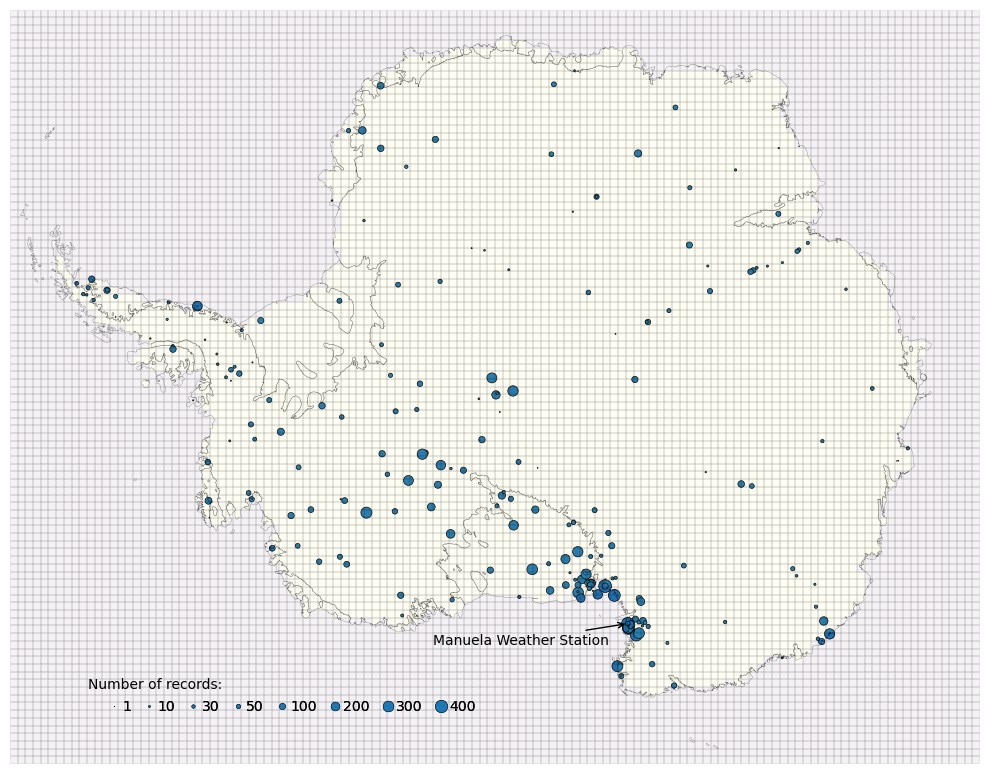

In [48]:
# Loading ice sheet shapefile 
icesheet_shapefile_path = '/home/jez/Bias_Correction_Application/walkthrough_tutorial/tutorial_data/icesheet_shapefile/icesheet.shp'
gdf_icesheet = gpd.read_file(icesheet_shapefile_path)

# Defining rotated coordinate system (glon,glat) and converting ice sheet shapefile to rotated coordinates
rotated_coord_system = ccrs.RotatedGeodetic(
    13.079999923706055,
    0.5199999809265137,
    central_rotated_longitude=180.0,
    globe=None,
)
gdf_icesheet_rotatedcoords = gdf_icesheet.to_crs(rotated_coord_system)

############################################################################################################

# Defining background map function
def background_map_rotatedcoords(ax):
    gdf_icesheet_rotatedcoords.boundary.plot(
        ax=ax,
        color='k',
        linewidth=0.3,
        alpha=0.4)
    ax.set_axis_off()

# Defining marker size legend function
def markersize_legend(ax, bins, scale_multipler, legend_fontsize=10,loc=3,ncols=1,columnspacing=0.8,handletextpad=0.1,bbox=(0.,0.)):
    ax.add_artist(
        ax.legend(
            handles=[
                mlines.Line2D(
                    [],
                    [],
                    color="tab:blue",
                    markeredgecolor="k",
                    markeredgewidth=0.3,
                    lw=0,
                    marker="o",
                    markersize=np.sqrt(b*scale_multipler),
                    label=str(int(b)),
                )
                for i, b in enumerate(bins)
            ],
            loc=loc,
            fontsize = legend_fontsize,
            ncols=ncols,
            columnspacing=columnspacing,
            handletextpad=handletextpad,
            bbox_to_anchor=bbox,
            framealpha=0,
        )
    )

############################################################################################################

# Plotting the weather station locations
fig, ax = plt.subplots(1, 1, figsize=(10, 10),dpi=100)#,frameon=False)
background_map_rotatedcoords(ax)
ax.scatter(
    ds_aws.glon,
    ds_aws.glat,
    s=ds_aws.count('t')['temperature']/5,
    edgecolor='k',
    linewidths=0.5,
)
ax.annotate(
    'Number of records:',
    xy=(0.08, 0.1), xycoords='axes fraction',
    fontsize=10)
markersize_legend(ax, [1,10,30,50,100,200,300,400], scale_multipler=1/5, legend_fontsize=10,loc=3,ncols=9,columnspacing=0.3,handletextpad=-0.4,bbox=(0.08,0.05))

# highlighting individual station
station = 'Manuela'
ax.annotate(
    f'{station} Weather Station',
    xy=(ds_aws.sel(station = station).glon, ds_aws.sel(station = station).glat), xycoords='data',
    xytext=(-140,-15), textcoords='offset points',
    arrowprops=dict(arrowstyle="->"),
    fontsize=10)

# Plotting the climate model grid
ds_climate['temperature'].mean('time').notnull().plot.pcolormesh(
    x='glon',
    y='glat',
    ax=ax,
    alpha=0.05,
    add_colorbar=False,
    edgecolor='k',
    linewidth=0.3,
)

plt.tight_layout()
plt.show()


We can see that the spatial distribution of weather stations is not very uniform. There's clearly a higher density of stations over West Antarctica than East Antarctica and there are certain regions with particularly high density clusters of observations. This is an important consideration and will induce a bias if the spatial distribution is not accounted for. Gaussian processes allow us to consider the spatial covariance between sites and thus partially accounts for the clustered distribution. Note there are potentially location selection biases that can't be accounted for using GPs, such as if many of the sites were chosen specifically because there's a lot of melt recorded nearby and so the temperature is anomalously high.  

### Single Weather Station Time Series and PDF Comparisons

For further context we'll plot the time series for a particular weather station, as well as the time series for the climate model output of the nearest grid-cell. 

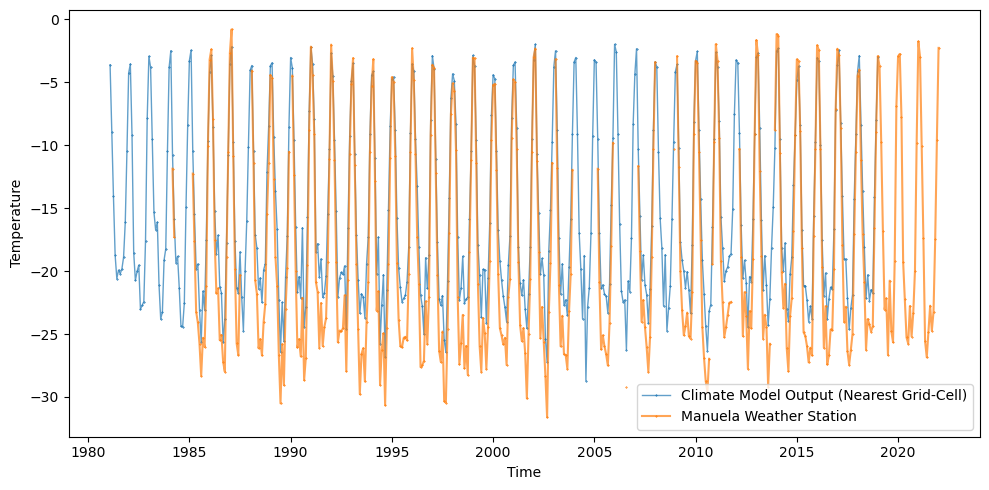

In [49]:
# Computing Nearest Neighbours
ds_climate_stacked = ds_climate.stack(x=('grid_longitude', 'grid_latitude'))
ds_climate_stacked_landonly = ds_climate_stacked.dropna('x')
ox = np.dstack([ds_aws['glon'],ds_aws['glat']])[0]
cx = np.dstack([ds_climate_stacked_landonly['glon'],ds_climate_stacked_landonly['glat']])[0]
nn_indecies = []
for point in ox:
    nn_indecies.append(distance.cdist([point], cx).argmin())
ds_climate_nearest_stacked = ds_climate_stacked_landonly.isel(x=nn_indecies)
ds_climate_nearest_stacked = ds_climate_nearest_stacked.assign_coords(nearest_station=("x", ds_aws.station.data))
ds_climate_nearest_stacked = ds_climate_nearest_stacked.swap_dims({"x": "nearest_station"})

# Single Site Full Time Series
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
station = 'Manuela'
ds_climate_nearest_stacked.sel(nearest_station = station)['temperature'].plot(x="t",
                                                                              ax=ax,
                                                                              hue='station',
                                                                              alpha=0.7,
                                                                              label='Climate Model Output (Nearest Grid-Cell)',
                                                                              marker='x',
                                                                              ms=1,
                                                                              color='tab:blue',
                                                                              linewidth=1.0)

ds_aws.sel(station = station)['temperature'].plot(ax=ax,
                                                hue='station',
                                                alpha=0.7,
                                                label=f'{station} Weather Station',
                                                marker='x',
                                                ms=1,
                                                color='tab:orange',
                                                linewidth=1.5)
xticks = np.arange(0,45*12,12*5)
xticklabels = np.arange(1980,2025,5)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_ylabel('Temperature')
ax.set_xlabel('Time')
ax.legend()
ax.set_title('')
plt.tight_layout()
plt.show()


The Manuela weather station has a comparatively high number of temperature records, which here spans from 1984-2021. The monthly temperature time series is plot and compared against the time series for the climate model output of the nearest grid-cell (which spans from 1981-2019). The variance in the time series are dominated by the seasonal cycle. While there appears to be a bias in the mean between the 2 time series, it's quite likely that this bias depends on the particular season. In this piece of work we define bias as differences in the parameters of the PDF for the 2 time series. The PDFs are plot below for the above time series.

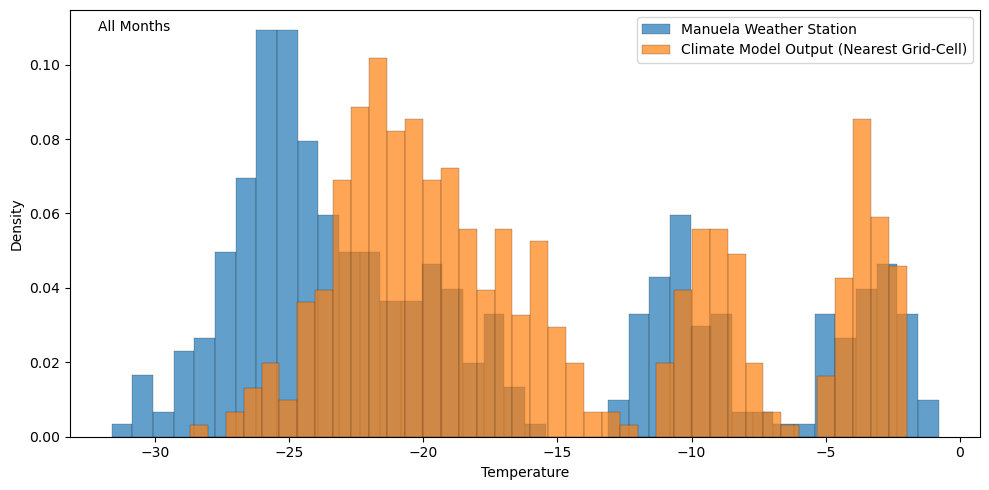

In [50]:
# Probability Density Function (all months)
station = 'Manuela'

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)
ds_aws.sel(station=station).to_dataframe()[['temperature']].hist(bins=40,
                                         ax=ax,
                                         edgecolor='k',
                                         linewidth=0.2,
                                         grid=False,
                                         density=1,
                                         alpha=0.7,
                                         label = f'{station} Weather Station',
                                         )
ds_climate_nearest_stacked.sel(nearest_station=station).to_dataframe()[['temperature']].hist(bins=40,
                                         ax=ax,
                                         edgecolor='k',
                                         linewidth=0.2,
                                         grid=False,
                                         density=1,
                                         alpha=0.7,
                                        label = 'Climate Model Output (Nearest Grid-Cell)',
                                         )
ax.annotate('All Months',xy=(0.03,0.95),xycoords='axes fraction')
ax.set_title('')
ax.set_xlabel('Temperature')
ax.set_ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


The PDFs for the whole time series are multi-modal, reflecting the seasonality of the data. Many parameters would be required to adequately describe the distribution and it's clear that defining the bias simply by differences in the means of the whole time series has limited value. For example, while the mean of the winter peak is ~5° higher for the climate model output, the means in the summer peak are approximately equal. While we could aim to parameterise this distribution, a more common approach is simply to split the time series up by the month, focusing on defining bias for each month separately. It is expected that for individual months the PDF will be Gaussian and the bias can be defined in terms of differences in the mean and variance between the in-situ weather station observations and the climate model output. The PDF split by month for the weather station data is shown below: 


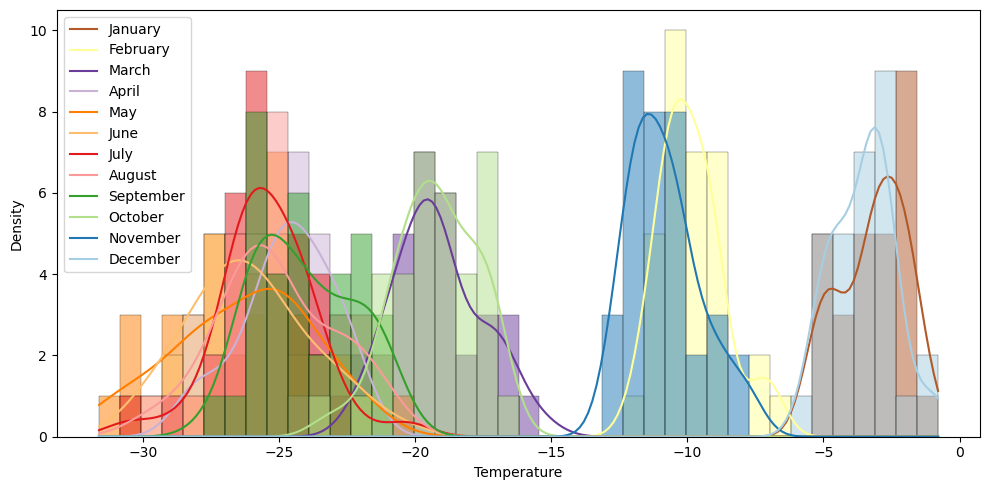

In [51]:
# Probability Density Function by Month
station = 'Manuela'

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi=100)

sns.histplot(data=ds_aws.sel(station=station).to_dataframe()[['month','temperature']],
            x='temperature',
            hue='month',
            bins=40,
            ax=ax,
            edgecolor='k',
            linewidth=0.2,
            kde=True,
            palette='Paired',
)

ax.set_title('')
ax.set_xlabel('Temperature')
ax.set_ylabel('Density')
plt.legend(['January','February','March','April','May','June','July','August','September','October','November','December'])
plt.tight_layout()
plt.show()

Taking just the month of June, the comparison between the time series for the Manuela weather station and climate model output of the nearest grid-cell are shown below:

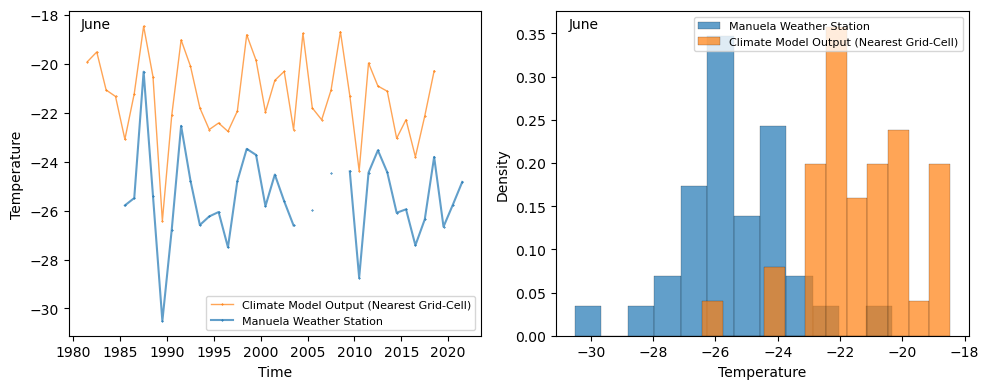

In [52]:
month = 6 
station = 'Manuela'

fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=100)

ax = axs[0]
ds_climate_nearest_stacked.sel(nearest_station = station).where(ds_climate_nearest_stacked['month']==month,drop=True)['temperature'].plot(
                                                                                                                                x='t',
                                                                                                                                ax=ax,
                                                                                                                                hue='station',
                                                                                                                                alpha=0.7,
                                                                                                                                label='Climate Model Output (Nearest Grid-Cell)',
                                                                                                                                marker='x',
                                                                                                                                ms=1,
                                                                                                                                color='tab:orange',
                                                                                                                                linewidth=1.0)
ds_aws.sel(station = station).where(ds_aws['month']==month,drop=True)['temperature'].plot(ax=ax,
                                                                                                hue='station',
                                                                                                alpha=0.7,
                                                                                                label=f'{station} Weather Station',
                                                                                                marker='x',
                                                                                                ms=1,
                                                                                                color='tab:blue',
                                                                                                linewidth=1.5)

ax.annotate('June',xy=(0.03,0.95),xycoords='axes fraction')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)#,rotation = 90)
ax.set_ylabel('Temperature')
ax.set_xlabel('Time')
ax.legend(fontsize=8)
ax.set_title('')

ax=axs[1]
ds_aws.sel(station=station).where(ds_aws['month']==month,drop=True).to_dataframe()[['temperature']].hist(bins=12,
                                         ax=ax,
                                         edgecolor='k',
                                         linewidth=0.2,
                                         grid=False,
                                         density=1,
                                         alpha=0.7,
                                         label = f'{station} Weather Station',
                                         )
ds_climate_nearest_stacked.sel(nearest_station=station).where(ds_climate_nearest_stacked['month']==month,drop=True).to_dataframe()[['temperature']].hist(bins=12,
                                         ax=ax,
                                         edgecolor='k',
                                         linewidth=0.2,
                                         grid=False,
                                         density=1,
                                         alpha=0.7,
                                        label = 'Climate Model Output (Nearest Grid-Cell)',
                                         )
ax.annotate('June',xy=(0.03,0.95),xycoords='axes fraction')
ax.set_title('')
ax.set_xlabel('Temperature')
ax.set_ylabel('Density')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


It's clear in the June time series comparison that the climate model performs well at capturing the yearly variability (beyond just seasonality) and is highly correlated with the weather station output. However, there's a clear bias in the mean of approximately 4°. The PDF for both time series is well represented by a Gaussian distribution and so we can meaningfully define bias with respect to differences in the mean and variance of the two time series. In the rest of this notebook we'll focus on just evaluating and correcting bias in the June temperature for simplicity. 

### Pairplots

Since we're interested in evaluating bias in the mean and variance of the June time series, it's useful to think about predictors that have an influence on these metrics. The two most obvious predictors are elevation and latitude, both of which have well-understood physical justification for the impact on the mean temperature. 

```{admonition} Note: Filtering
:class: note
Note that we filter to just June records as discussed above and also that since here we're just doing exploratory analysis we filter to only include stations with more than 5 records to limit the influence of uncertainty in the empirical estimates. 
```

```{admonition} Note: Nearest Grid Cells
:class: note
Note that we also include a subcategory 'Climate Model Nearest' that represent values for just the climate model grid-cells nearest to each AWS. This is to get a feel for how representative the AWS samples are of Antarctic-wide region (e.g. it might be that differences between the datasets are just the result of the particular sample of locations with weather stations). 
```

/home/jez/miniconda3/envs/BCA/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jez/miniconda3/envs/BCA/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


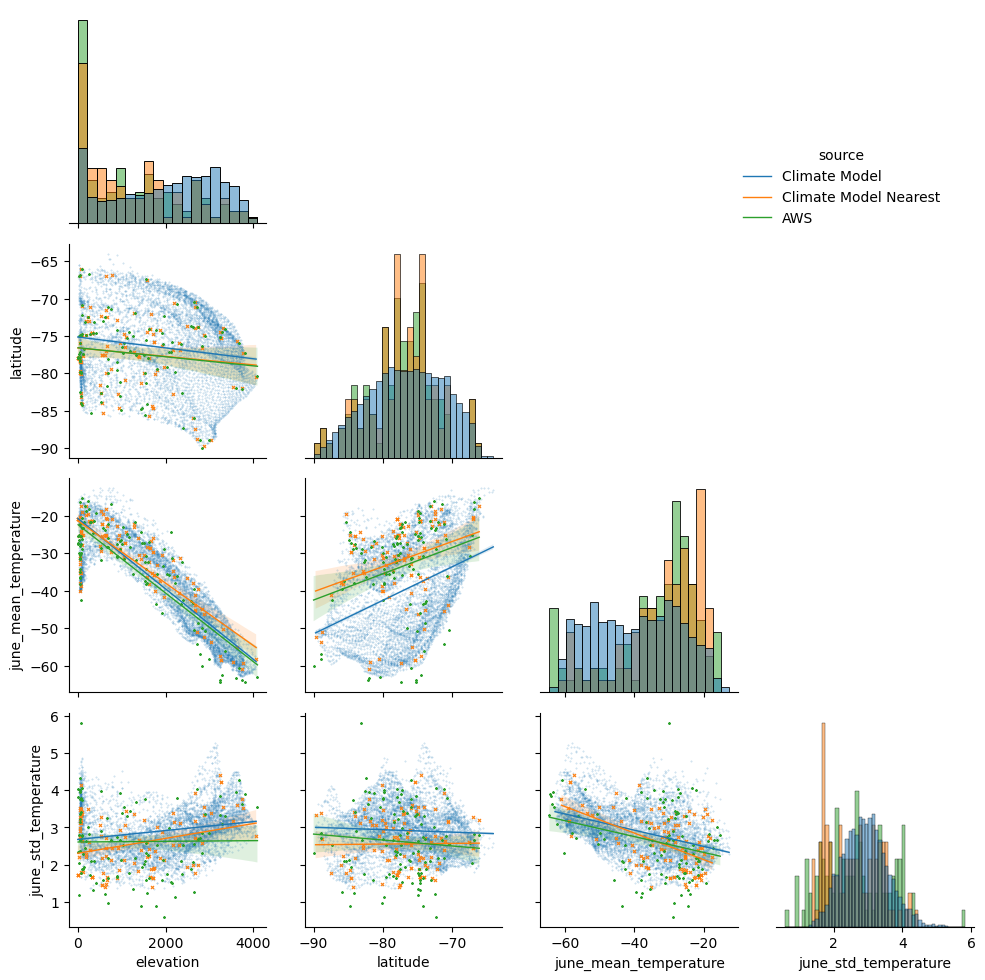

In [53]:
# Computing June Mean and Standard Deviation
ds_aws['june_mean_temperature'] = ds_aws.where(ds_aws['month']==6).mean('t')['temperature']
ds_aws['june_std_temperature'] = ds_aws.where(ds_aws['month']==6).std('t')['temperature']
ds_climate_stacked_landonly['june_mean_temperature'] = ds_climate_stacked_landonly.where(ds_climate_stacked_landonly['month']==6).mean('time')['temperature']
ds_climate_stacked_landonly['june_std_temperature'] = ds_climate_stacked_landonly.where(ds_climate_stacked_landonly['month']==6).std('time')['temperature']
ds_climate_nearest_stacked['june_mean_temperature'] = ds_climate_nearest_stacked.where(ds_climate_nearest_stacked['month']==6).mean('time')['temperature']
ds_climate_nearest_stacked['june_std_temperature'] = ds_climate_nearest_stacked.where(ds_climate_nearest_stacked['month']==6).std('time')['temperature']

# Creating june records filter
ds_aws['june_temperature_records'] = ds_aws.where(ds_aws['month']==6).count('t')['temperature']
stations_recordsfilter_june = ds_aws.where(ds_aws['june_temperature_records']>5,drop=True)['station'].data

ds_aws_filtered = ds_aws.sel(station=stations_recordsfilter_june)
ds_climate_nearest_stacked_filtered = ds_climate_nearest_stacked.sel(nearest_station=stations_recordsfilter_june)

# Transforming data for plotting with seaborn PairGrid 
vars = ['elevation','latitude','june_mean_temperature','june_std_temperature']
df_climate = ds_climate_stacked_landonly[vars].to_dataframe()[vars].reset_index(drop=True)
df_climate_nearest_filtered = ds_climate_nearest_stacked_filtered[vars].to_dataframe()[vars].reset_index(drop=True)
df_aws_filtered = ds_aws_filtered[vars].to_dataframe()[vars].reset_index(drop=True)
df_climate['source'] = 'Climate Model'
df_climate_nearest_filtered['source'] = 'Climate Model Nearest'
df_aws_filtered['source'] = 'AWS'
df_combined = pd.concat([df_climate,df_climate_nearest_filtered,df_aws_filtered],axis=0).reset_index(drop=True)

# Plotting PairGrid with regression lines
g = sns.PairGrid(df_combined, hue='source',diag_sharey=False, corner=True)

reg_kws = {'scatter': False, 'line_kws':{'linewidth':1}}
g.map_lower(sns.regplot,**reg_kws)
g.add_legend(bbox_to_anchor=(0.8,0.8),markerscale=3)

g.hue_kws = {'marker':['+','x','*'],'s':[2,5,2],'alpha':[0.2,1,1]}
scatter_kws = {'linewidth':0.8}
g.map_lower(plt.scatter,**scatter_kws)

hist_kws = {'common_norm':False,'stat':'density'}
g.map_diag(sns.histplot,**hist_kws)

The pairplots bring up some interesting features:
- Comparisons of the histograms between the 'Climate Model' data (representing all grid-cells across the domain) and the 'Climate Model Nearest' data (representing only climate model data from grid-cells closest to the weather stations) indicate that the AWS sites are not a particularly representative sample of the whole Antarctic region (higher proportion of sites at zero elevation, clusters of sites at particular locations and so latitudes, disproportionality high number of sites at regions with relatively high mean temperatures and relatively low standard deviations).
- There's clear relationships between mean temperature with elevation and latitude. The relationship with latitude is shown to depend on the subsampling of the AWS locations. 
- There's only a weak relationship between the standard deviation in temperature with elevation and latitude. As a result we'll leave out these predictors when estimating the standard deviation across the domain. 
- The behaviour of the relationship between elevation with mean temperature appears quite different at zero elevation sites, which could be linked with various factors such as the proximity and impact of the nearby sea on zero elevation sites. This potentially indicates at the utility of incorporating a distance to the coast predictor, although for this tutorial we leave this out.  

### Examining spatial covariance after removing influence of elevation and latitude

The spatial pattern in mean temperature is currently dominated by the relationship with elevation and latitude. While these are clearly important predictors for mean temperature, it's expected that there'll be various other important factors that impact mean temperature but are harder to account for (e.g. the funneling of wind down valleys will impact the mean temperature). One way of at least partially accounting for these factors is to model the spatial covariance between sites after removing the influence of elevation and latitude. That is that nearby sites are likely to be highly correlated as the factors impacting them are similar, whereas the further away you go the less correlated the sites will be (different valleys with different wind patterns etc). Here we'll plot the spatial pattern in the mean temperature after removing the linear influence of elevation and latitude:

In [54]:
# Defining predictors and scaling
predictors = ['elevation','latitude']
scaled_predictors = [i+'_scaled' for i in predictors]
target = 'june_mean_temperature'

scaler = StandardScaler()
df_aws_filtered_scaled_predictors = pd.DataFrame(scaler.fit_transform(df_aws_filtered[predictors]),columns=scaled_predictors)
df_climate_scaled_predictors = pd.DataFrame(scaler.transform(df_climate[predictors]),columns=scaled_predictors)

# Linear Regression AWS
print("Linear Regression AWS:")
model = LinearRegression()
model.fit(df_aws_filtered_scaled_predictors,df_aws_filtered[target])
df_aws_filtered['june_mean_temperature_predicted_lr'] = model.predict(df_aws_filtered_scaled_predictors)
feature_importance = pd.Series(model.coef_, index=scaled_predictors)
print('intercept:',model.intercept_)
print(feature_importance.sort_values(ascending=False,key=abs))

# Linear Regression Climate Model
print("\n Linear Regression Climate Model:")
model = LinearRegression()
model.fit(df_climate_scaled_predictors,df_climate[target])
df_climate['june_mean_temperature_predicted_lr'] = model.predict(df_climate_scaled_predictors)
feature_importance = pd.Series(model.coef_, index=scaled_predictors)
print('intercept:',model.intercept_)
print(feature_importance.sort_values(ascending=False,key=abs))

ds_climate_stacked_landonly['june_mean_temperature_predicted_lr'] = (
    ('x'),
    df_climate['june_mean_temperature_predicted_lr'])

ds_aws_filtered['june_mean_temperature_predicted_lr'] = (
    ('station'),
    df_aws_filtered['june_mean_temperature_predicted_lr'])

ds_climate_stacked_landonly['june_mean_temperature_residual_lr']=ds_climate_stacked_landonly['june_mean_temperature']-ds_climate_stacked_landonly['june_mean_temperature_predicted_lr']
ds_aws_filtered['june_mean_temperature_residual_lr']=ds_aws_filtered['june_mean_temperature']-ds_aws_filtered['june_mean_temperature_predicted_lr']

ds_climate_stacked = xr.merge([ds_climate_stacked,ds_climate_stacked_landonly])


Linear Regression AWS:
intercept: -33.625017170326736
elevation_scaled   -10.160912
latitude_scaled      1.952785
dtype: float64

 Linear Regression Climate Model:
intercept: -33.094520306833495
elevation_scaled   -10.223010
latitude_scaled      2.895803
dtype: float64


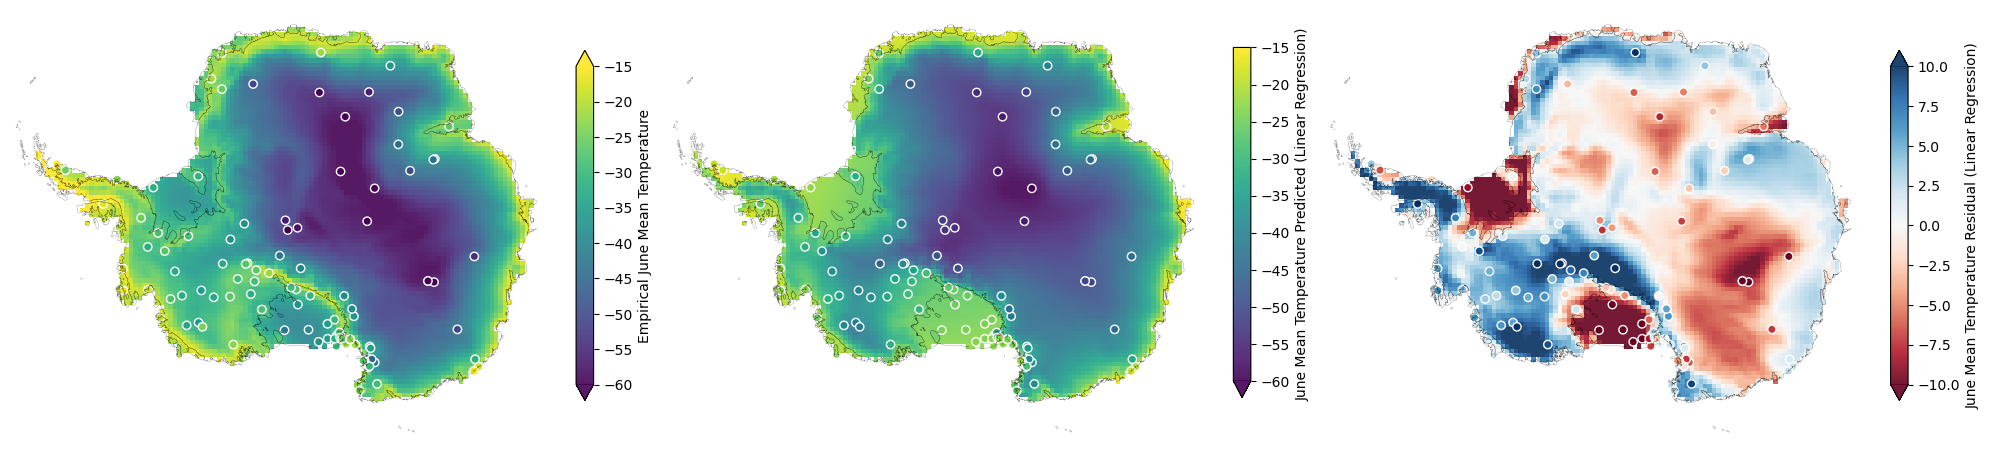

In [55]:
# Plotting the linear regression prediction and residual
fig, axs = plt.subplots(1, 3, figsize=(20, 5),dpi=100)#,frameon=False)

metrics = ['june_mean_temperature','june_mean_temperature_predicted_lr','june_mean_temperature_residual_lr']
cmaps = ['viridis','viridis','RdBu']
vminmaxs = [(-60,-15),(-60,-15),(-10,10)]
labels = ['Empirical June Mean Temperature','June Mean Temperature Predicted (Linear Regression)','June Mean Temperature Residual (Linear Regression)']

for ax,metric,vminmax,cmap,label in zip(axs,metrics,vminmaxs,cmaps,labels):
    background_map_rotatedcoords(ax)

    ds_climate_stacked[metric].unstack().plot.pcolormesh(
        x='glon',
        y='glat',
        ax=ax,
        alpha=0.9,
        vmin=vminmax[0],
        vmax=vminmax[1],
        cmap=cmap,
        cbar_kwargs = {'fraction':0.030,
                    'pad':0.02,
                    'label':label}
    )

    ax.scatter(
        ds_aws_filtered['glon'],
        ds_aws_filtered['glat'],
        marker="o",
        c=ds_aws_filtered[metric],
        cmap=cmap,
        edgecolor="w",
        linewidth=1.0,
        vmin=vminmax[0],
        vmax=vminmax[1],
    )

    ax.set_axis_off()
    ax.set_title('')
                       
plt.tight_layout()


### Examining spatial covariance in the bias

It's useful to also examine the spatial structure of the bias both in the mean and standard deviation of june temperature. We do this after accounting for the linear relationship with elevation and latitude (that is we examine the spatial structure in the bias of the residuals). For the standard deviation, we first apply a log transformation to get the metric on the -$\infty,\infty$ domain, then we take away a constant equal to the average, then we examine the bias in the difference in the zero-mean log(standard deviations) between each dataset.

In [56]:
# Recomputing nearest neighbours
ds_climate_nearest_stacked = ds_climate_stacked_landonly.isel(x=nn_indecies)
ds_climate_nearest_stacked = ds_climate_nearest_stacked.assign_coords(nearest_station=("x", ds_aws.station.data))
ds_climate_nearest_stacked = ds_climate_nearest_stacked.swap_dims({"x": "nearest_station"})
ds_climate_nearest_stacked_filtered = ds_climate_nearest_stacked.sel(nearest_station=stations_recordsfilter_june)

# Evaluating bias in residuals from linear regression for the mean temperature
ds_climate_nearest_stacked_filtered['bias_june_mean_temperature_residual_lr'] = (
    ('nearest_station'),
    ds_climate_nearest_stacked_filtered['june_mean_temperature_residual_lr'].data - ds_aws_filtered['june_mean_temperature_residual_lr'].data)

ds_climate_stacked['june_logstd_temperature']=np.log(ds_climate_stacked['june_std_temperature'])
ds_climate_nearest_stacked_filtered['june_logstd_temperature']=np.log(ds_climate_nearest_stacked_filtered['june_std_temperature'])
ds_aws_filtered['june_logstd_temperature']=np.log(ds_aws_filtered['june_std_temperature'])

ds_climate_stacked['june_logstd_temperature_residual_constant'] = ds_climate_stacked['june_logstd_temperature'] - ds_climate_stacked['june_logstd_temperature'].mean()
ds_climate_nearest_stacked_filtered['june_logstd_temperature_residual_constant']=ds_climate_nearest_stacked_filtered['june_logstd_temperature'] - ds_climate_nearest_stacked_filtered['june_logstd_temperature'].mean()
ds_aws_filtered['june_logstd_temperature_residual_constant']=ds_aws_filtered['june_logstd_temperature']-ds_aws_filtered['june_logstd_temperature'].mean()

# Evaluating bias for the log(std) temperature
ds_climate_nearest_stacked_filtered['bias_june_logstd_temperature_residual_constant'] = (
    ('nearest_station'),
    ds_climate_nearest_stacked_filtered['june_logstd_temperature_residual_constant'].data - ds_aws_filtered['june_logstd_temperature_residual_constant'].data)

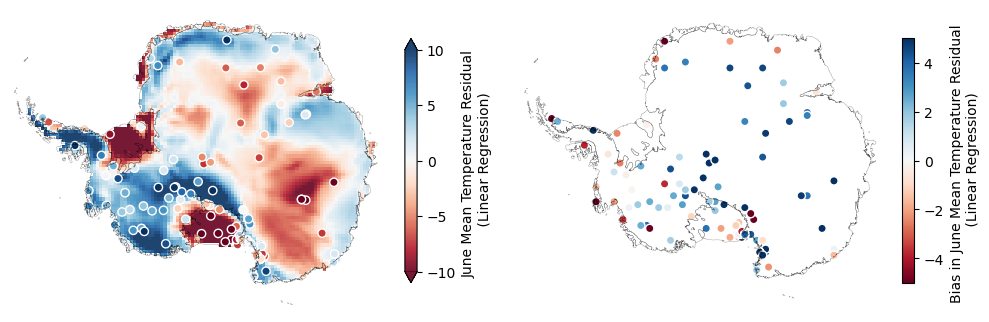

In [57]:
# Plotting the linear regression residual and bias in the residual for the mean temperature
fig, axs = plt.subplots(1, 2, figsize=(10, 5),dpi=100)#,frameon=False)

for ax in axs:
    background_map_rotatedcoords(ax)
    ax.set_axis_off()
    ax.set_title('')

ax=axs[0]

ds_climate_stacked['june_mean_temperature_residual_lr'].unstack().plot.pcolormesh(
    x='glon',
    y='glat',
    ax=ax,
    alpha=0.9,
    vmin=-10,
    vmax=10,
    cmap='RdBu',
    cbar_kwargs = {'fraction':0.030,
                'pad':0.02,
                'label':'June Mean Temperature Residual \n (Linear Regression)'}
)

ax.scatter(
    ds_aws_filtered['glon'],
    ds_aws_filtered['glat'],
    marker="o",
    c=ds_aws_filtered['june_mean_temperature_residual_lr'],
    cmap='RdBu',
    edgecolor="w",
    linewidth=1.0,
    vmin=-10,
    vmax=10,
)

ax=axs[1]

plot = ax.scatter(
    ds_climate_nearest_stacked_filtered['glon'],
    ds_climate_nearest_stacked_filtered['glat'],
    marker="o",
    c=ds_climate_nearest_stacked_filtered['bias_june_mean_temperature_residual_lr'],
    cmap='RdBu',
    edgecolor="w",
    linewidth=1.0,
    vmin=-5,
    vmax=5,
)

plt.colorbar(plot, ax=ax, fraction=0.03, pad=0.02,label='Bias in June Mean Temperature Residual \n (Linear Regression)')#, orientation='horizontal', label=metric)

plt.tight_layout()

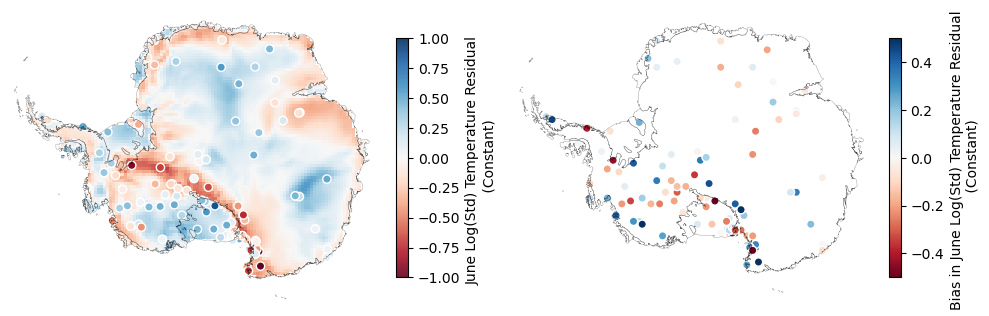

In [58]:
# Plotting the linear regression residual and bias in the residual for the mean temperature
fig, axs = plt.subplots(1, 2, figsize=(10, 5),dpi=100)#,frameon=False)

for ax in axs:
    background_map_rotatedcoords(ax)
    ax.set_axis_off()
    ax.set_title('')

ax=axs[0]

ds_climate_stacked['june_logstd_temperature_residual_constant'].unstack().plot.pcolormesh(
    x='glon',
    y='glat',
    ax=ax,
    alpha=0.9,
    vmin=-1,
    vmax=1,
    cmap='RdBu',
    cbar_kwargs = {'fraction':0.030,
                'pad':0.02,
                'label':'June Log(Std) Temperature Residual \n (Constant)'}
)

ax.scatter(
    ds_aws_filtered['glon'],
    ds_aws_filtered['glat'],
    marker="o",
    c=ds_aws_filtered['june_logstd_temperature_residual_constant'],
    cmap='RdBu',
    edgecolor="w",
    linewidth=1.0,
    vmin=-1,
    vmax=1,
)

ax=axs[1]

plot = ax.scatter(
    ds_climate_nearest_stacked_filtered['glon'],
    ds_climate_nearest_stacked_filtered['glat'],
    marker="o",
    c=ds_climate_nearest_stacked_filtered['bias_june_logstd_temperature_residual_constant'],
    cmap='RdBu',
    edgecolor="w",
    linewidth=1.0,
    vmin=-0.5,
    vmax=0.5,
)

plt.colorbar(plot, ax=ax, fraction=0.03, pad=0.02,label='Bias in June Log(Std) Temperature Residual \n (Constant)')#, orientation='horizontal', label=metric)

plt.tight_layout()

There's clearly spatial auto-correlation in the mean and log(std) parameters across the domain. Additionally, the spatial pattern is similar across both the AWS and climate model datasets. There also appears to be spatial auto-correlation in the bias of these parameters. For the mean parameter, the correlation length-scale appears to be greater in the bias than the unbiased values. 

### Examining relationships between variables and the bias in parameters

It's useful to check if there's any obvious relationships between the predictors and unbiased parameter values with the biased parameter values as this can impact our model. This is done through a partial pairplot as shown below:

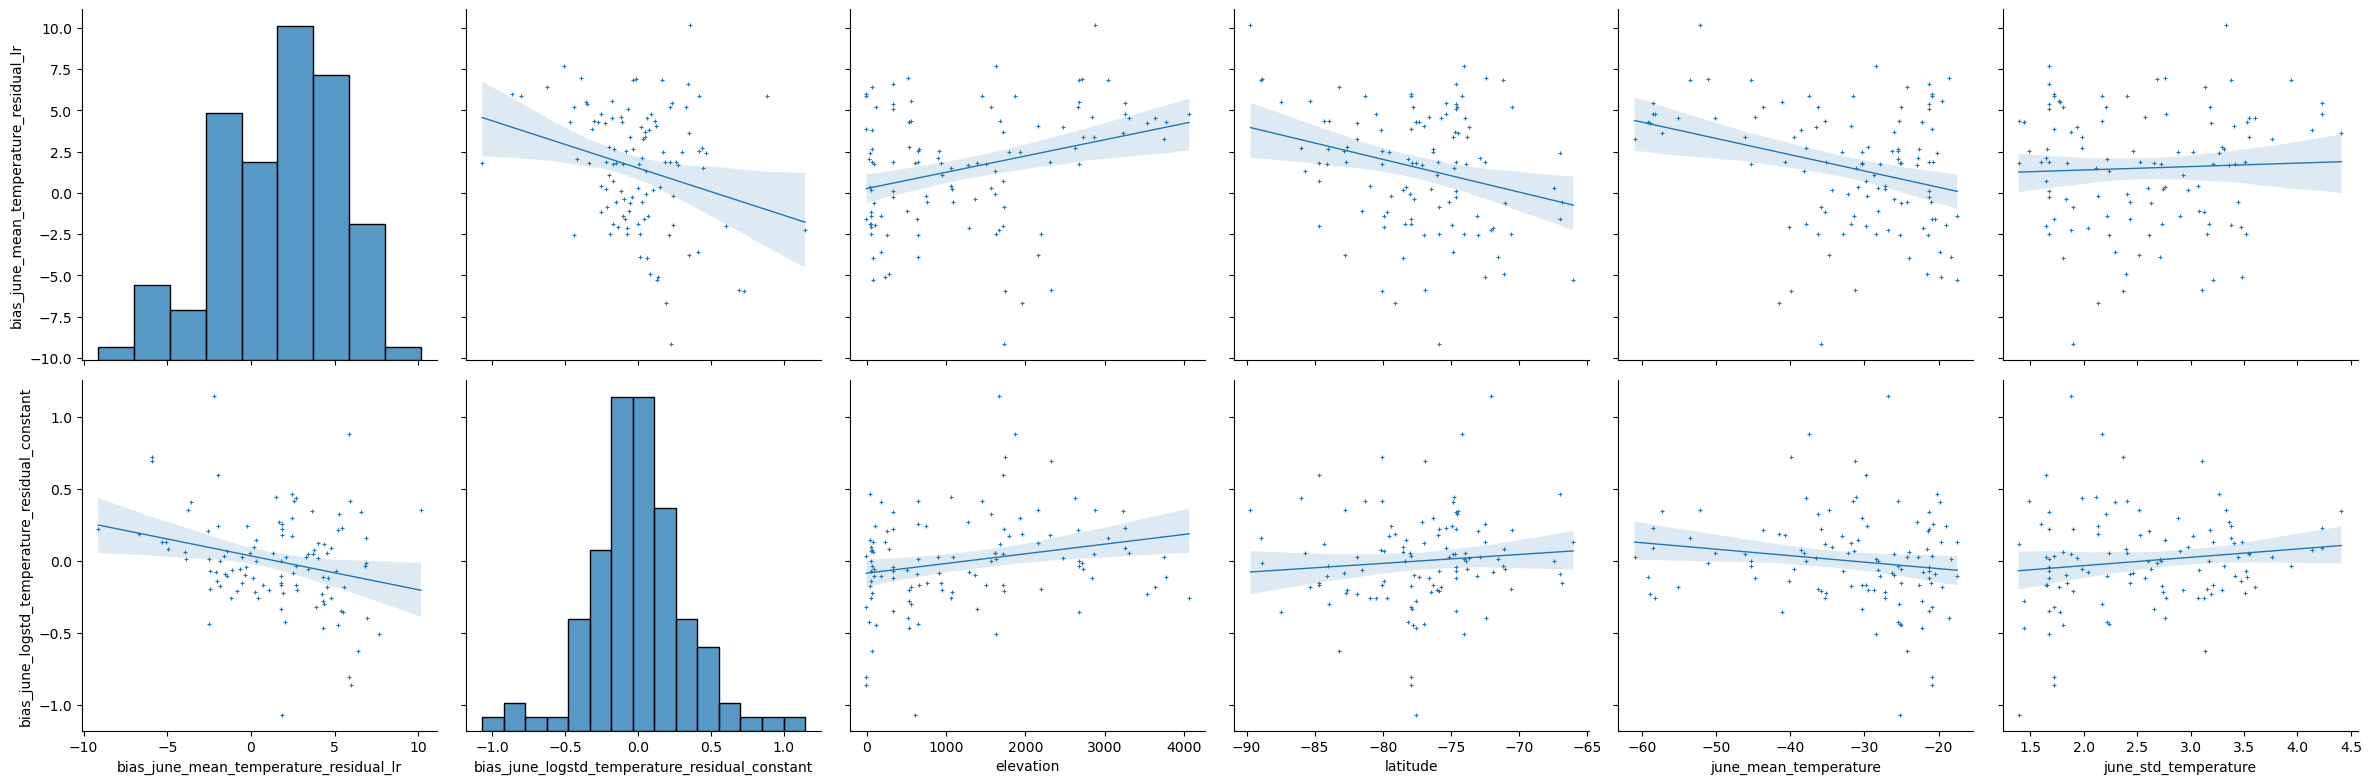

In [59]:
# Transforming data for plotting with seaborn PairGrid 
vars = ['elevation','latitude','june_mean_temperature','june_std_temperature','bias_june_mean_temperature_residual_lr','bias_june_logstd_temperature_residual_constant']
x_vars = ['bias_june_mean_temperature_residual_lr','bias_june_logstd_temperature_residual_constant','elevation','latitude','june_mean_temperature','june_std_temperature']
y_vars = ['bias_june_mean_temperature_residual_lr','bias_june_logstd_temperature_residual_constant']
df_bias_climate = ds_climate_nearest_stacked_filtered[vars].to_dataframe()[vars].reset_index(drop=True)

# Plotting PairGrid with regression lines
g = sns.PairGrid(df_bias_climate, x_vars=x_vars,y_vars=y_vars,height=4,diag_sharey=False)#, corner=True)

reg_kws = {'scatter': False, 'line_kws':{'linewidth':1}}
g.map_offdiag(sns.regplot,**reg_kws)

g.hue_kws = {'marker':['+'],'s':[5],'alpha':[1.0]}
scatter_kws = {'linewidth':0.8}
g.map_offdiag(plt.scatter,**scatter_kws)

hist_kws = {'common_norm':False,'stat':'density'}
g.map_diag(sns.histplot,**hist_kws)

The above pairplot only shows weak relationships between the bias in parameters and the other variables. Therefore, in the model we'll assume the bias is generated from an independent underlying process. 

## Data Preprocessing

For the purpose of this notebook we'll do minimal data preprocessing. The main things we'll focus on are simply scaling the elevation and latitude predictors and removing any AWS sites with only 2 records for average June temperature. All the data is transformed away from Xarray and into a dictionary of device arrays (JAX versions of Numpy arrays) of the right shape that the inference package Numpyro expects. A subsample of the climate model grid-cells is also chosen to reduce the computational cost of inference in this notebook. 

```{admonition} Note: Feature Engineering and Outliers etc. 
:class: note
Note that while extremely useful and flexible, the computational demands of GPs is often described as their Achilles' heel.  Typically, the time for inference scales as the cube of the number of data points, which is a result of taking the inverse of the covariance matrix when computing the likelihood of a set of data for given hyper-parameters. There are however, various methods for improving the speed of inference, such as sparse variational Gaussian processes (SVGPs). Although, not these are not utilised in this notebook. Instead we do the sub-optimal procedure of simply only using a small section of the climate data.
```

```{admonition} Note: Feature Engineering and Outliers etc. 
:class: note
Note that some pre-filtering has already been conducted to the data made available for the notebook, such as removing weather stations located on Islands and filtering the climate model output to land onlu etc. These steps can be found in the preprocessing.py file of the notebook repository. 

Note also that there's often various additional data preprocessing steps to consider based on exploratory analysis, such as: whether or not to include outliers and whether they're important to the scientific question at hand; and what additional predictor features could be derived such as distance to the coast.   
```

In [60]:
# Filtering to June records and stations with more than 2 records
aws_june_filter = ds_aws.where(ds_aws['month']==6,drop=True)['t'].data
ds_aws_preprocessed = ds_aws.sel(t=aws_june_filter)
aws_stations_recordsfilter = ds_aws_preprocessed.where(ds_aws_preprocessed['temperature'].count(['t'])>2,drop=True)['station'].data
ds_aws_preprocessed = ds_aws_preprocessed.sel(station=aws_stations_recordsfilter)

climate_june_filter = ds_climate.where(ds_climate['month']==6,drop=True)['time'].data
ds_climate_preprocessed = ds_climate.sel(time=climate_june_filter)
ds_climate_preprocessed = ds_climate_preprocessed.stack(x=('grid_longitude', 'grid_latitude'))
ds_climate_preprocessed = ds_climate_preprocessed.dropna('x')
random_sample = np.random.choice(np.arange(len(ds_climate_preprocessed['x'])), size=200, replace=False)
ds_climate_preprocessed = ds_climate_preprocessed.isel(x=random_sample)

# Scaling latitude and elevation 
lat_scalar = StandardScaler()
ele_scalar = StandardScaler()
ds_aws_preprocessed['latitude_scaled'] = (['station'],  lat_scalar.fit_transform(ds_aws_preprocessed['latitude'].data.reshape(-1,1))[:,0])
ds_aws_preprocessed['elevation_scaled'] = (['station'], ele_scalar.fit_transform(ds_aws_preprocessed['elevation'].data.reshape(-1,1))[:,0])
ds_climate_preprocessed['latitude_scaled'] = (['x'], lat_scalar.transform(ds_climate_preprocessed['latitude'].data.reshape(-1,1))[:,0])
ds_climate_preprocessed['elevation_scaled'] = (['x'], ele_scalar.transform(ds_climate_preprocessed['elevation'].data.reshape(-1,1))[:,0])

# Transforming into dictionary of device arrays
ox = jnp.array(np.dstack([ds_aws_preprocessed['glon'],ds_aws_preprocessed['glat']]))[0]
odata = jnp.array(ds_aws_preprocessed['temperature'].values).transpose()
olat = jnp.array(ds_aws_preprocessed['latitude'].values)
oele = jnp.array(ds_aws_preprocessed['elevation'].values)
olat_scaled = jnp.array(ds_aws_preprocessed['latitude_scaled'].values)
oele_scaled = jnp.array(ds_aws_preprocessed['elevation_scaled'].values)

cx = jnp.array(np.dstack([ds_climate_preprocessed['glon'],ds_climate_preprocessed['glat']]))[0]
cdata = jnp.array(ds_climate_preprocessed.transpose()['temperature'].values).transpose()
clat = jnp.array(ds_climate_preprocessed['latitude'].values)
cele = jnp.array(ds_climate_preprocessed['elevation'].values)
clat_scaled = jnp.array(ds_climate_preprocessed['latitude_scaled'].values)
cele_scaled = jnp.array(ds_climate_preprocessed['elevation_scaled'].values)

data_dictionary = {
    'ds_aws_preprocessed':ds_aws_preprocessed,
    'ds_climate_preprocessed':ds_climate_preprocessed,
    'ox':ox,
    'odata':odata,
    'olat':olat,
    'oele':oele,
    'olat_scaled':jnp.array(olat_scaled),
    'oele_scaled':jnp.array(oele_scaled),
    'cx':cx,
    'cdata':cdata,
    'clat':clat,
    'cele':cele,
    'clat_scaled':jnp.array(clat_scaled),
    'cele_scaled':jnp.array(cele_scaled),
    'ele_scaler':ele_scalar,
    'lat_scaler':lat_scalar,
}

It's worth plotting the locations of the sampled climate model grid-cells and it's also worth performing a quick sanity check that the data is in the right format:

In [61]:
#Sanity Check
print('Data Shapes: \n',
      f'ox.shape:{ox.shape} \n',
      f'oele_scaled.shape:{oele_scaled.shape} \n',
      f'olat_scaled.shape:{olat_scaled.shape} \n',
      f'odata.shape:{odata.shape} \n',
      f'cx.shape:{cx.shape} \n',
      f'cele_scaled.shape:{cele_scaled.shape} \n',
      f'clat_scaled.shape:{clat_scaled.shape} \n',
      f'cdata.shape:{cdata.shape} \n',
      )
print('Data Values: \n',
      f'ox: min={ox.min():.1f}, mean={ox.mean():.1f}, max={ox.max():.1f} \n',
      f'odata: min={np.nanmin(odata):.1f}, mean={np.nanmean(odata):.1f}, max={np.nanmax(odata):.1f} \n',
      f'oele: min={oele.min():.1f}, mean={oele.mean():.1f}, max={oele.max():.1f} \n',
      f'olat: min={olat.min():.1f}, mean={olat.mean():.1f}, max={olat.max():.1f} \n',
      f'oele_scaled: min={oele_scaled.min():.1f}, mean={oele_scaled.mean():.1f}, max={oele_scaled.max():.1f} \n',
      f'olat_scaled: min={olat_scaled.min():.1f}, mean={olat_scaled.mean():.1f}, max={olat_scaled.max():.1f} \n',
      f'cx: min={cx.min():.1f}, mean={cx.mean():.1f}, max={cx.max():.1f} \n',
      f'cdata: min={np.nanmin(cdata):.1f}, mean={np.nanmean(cdata):.1f}, max={np.nanmax(cdata):.1f} \n',
      f'cele: min={cele.min():.1f}, mean={cele.mean():.1f}, max={cele.max():.1f} \n',
      f'clat: min={clat.min():.1f}, mean={clat.mean():.1f}, max={clat.max():.1f} \n',
      f'cele_scaled: min={cele_scaled.min():.1f}, mean={cele_scaled.mean():.1f}, max={cele_scaled.max():.1f} \n',
      f'clat_scaled: min={clat_scaled.min():.1f}, mean={clat_scaled.mean():.1f}, max={clat_scaled.max():.1f} \n',
)

Data Shapes: 
 ox.shape:(156, 2) 
 oele_scaled.shape:(156,) 
 olat_scaled.shape:(156,) 
 odata.shape:(42, 156) 
 cx.shape:(200, 2) 
 cele_scaled.shape:(200,) 
 clat_scaled.shape:(200,) 
 cdata.shape:(38, 200) 

Data Values: 
 ox: min=-24.0, mean=-1.7, max=21.5 
 odata: min=-70.3, mean=-33.4, max=-7.9 
 oele: min=5.0, mean=1246.4, max=4093.0 
 olat: min=-90.0, mean=-76.4, max=-65.2 
 oele_scaled: min=-1.1, mean=0.0, max=2.5 
 olat_scaled: min=-2.6, mean=-0.0, max=2.1 
 cx: min=-23.6, mean=2.4, max=23.9 
 cdata: min=-73.2, mean=-39.8, max=-7.2 
 cele: min=15.9, mean=1978.6, max=4058.8 
 clat: min=-89.2, mean=-76.7, max=-65.7 
 cele_scaled: min=-1.1, mean=0.7, max=2.5 
 clat_scaled: min=-2.5, mean=-0.1, max=2.0 



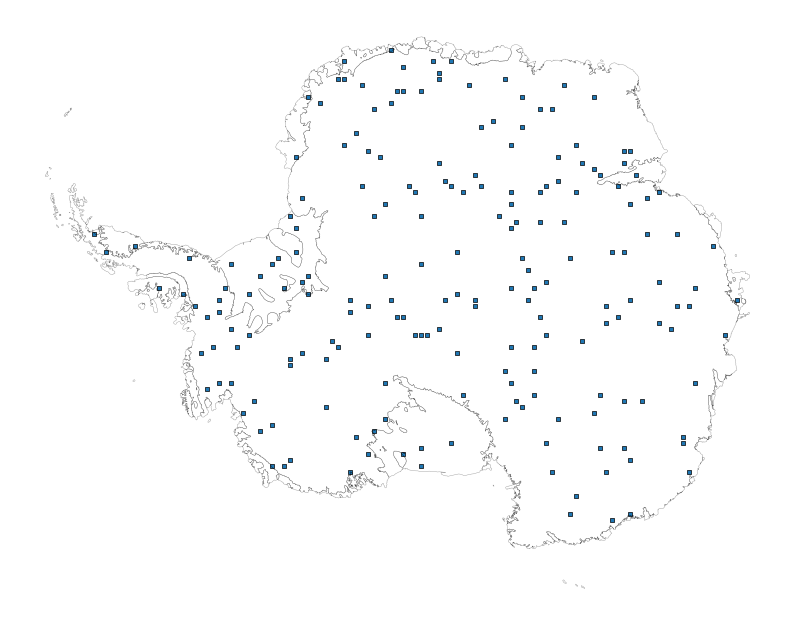

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10),dpi=100)#,frameon=False)
background_map_rotatedcoords(ax)
ax.scatter(
    ds_climate_preprocessed['glon'],
    ds_climate_preprocessed['glat'],
    marker='s',
    s=10,
    edgecolor='k',
    linewidths=0.5,
)

The approach of simply randomly sampling the climate model grid-cells is clearly sub-optimal as it doesn't target the regions of most interest, however, hopefully it'll still produce sensible results and be sufficient for this tutorial example.  

## Defining the model

![alt text](walkthrough_tutorial/model_diagram.png "Title")

$Y(s,t)$ represents the random variable for the unbiased AWS data at a particular time and location.
$Z(s,t)$ represents the random variable for the biased climate model output data at a particular time and location.

We say that the random variables $Y(s,t)$ and $Z(s,t)$ are distributed as normal distributions, such that $Y(s,t)\sim \mathcal{N}(\mu_Y(s),\tilde{\sigma}_Y(s))$ and $Z(s,t)\sim \mathcal{N}(\mu_Z(s),\tilde{\sigma}_Z(s))$. Note that $\tilde{\sigma}=log(\sigma)$, which is done to put the parameter on the sample space of Gaussian Processes (-$\infty,\infty$).

The parameters $\mu_Z(s)$ and $\tilde{\sigma}_Z(s)$ are considered as composed of an unbiased and biased component, such that $\mu_Z(s)=\mu_Y(s)+\mu_B(s)$ and $\tilde{\sigma}_Z(s)=\tilde{\sigma}_Y(s)+\tilde{\sigma}_B(s)$. Each of these components are then modelled across the domain as generated from Gaussian Processes. The GP captures the spatial covariance between nearby sites and defines a probability over a particular surface of values for the parameter. The GP is defined by a mean and covariance function. 

$\mu_Y(S) \sim \mathcal{GP}(m_{\mu_Y|\beta_{\mu_Y}},k(s,s'|))$
rσ˜B
(s) ∼ GP(0, k(s, s0
|vσ˜B
, lσ˜B
))

Based on our exploratory analysis the mean function is taken as constant for $\mu_B(s)$, $\tilde{\sigma}_Y(s)$,$\tilde{\sigma}_B(s)$, while for $\mu_Y(s)$ we parameterise the mean function as a linear function of elevation and latitude, such that $m_{\mu_Y}=\beta_{0,\mu_Y} + \beta_{1,\mu_Y} \cdot x_{ele} + \beta_{1,\mu_Y} \cdot x_{lat}$. 

The covariance function for each parameter is parameterised as a function of distance (|x-x'|) using a Matern3/2 kernel with lengthscale $l$ and variance $v$, such that: $k_{M^{3/2}}(x,x')=v(1+\dfrac{\sqrt{3}|x-x'|}{l}exp\left({-\dfrac{\sqrt{3}|x-x'|}{l}}\right)$. The distance is computed from the 'grid_latitude' and 'grid_longitude' coordinates, which are approximately Euclidean across the domain. The matern3/2 kernel is a popular choice for real-world data applications, see this blog by Andy Jones for some additional info: [The Matérn class of covariance functions
](https://andrewcharlesjones.github.io/journal/matern-kernels.html).

### Splitting up the Model

It's quite common when using Gaussian processes to fit the mean function independently of the covariance function. That is to say a mean function is fit to the data initially and then the zero-mean data is fit using the GP implementation that handles covariances between points. While we won't go into the reasons for this, there are various factors such as making the covariance matrix more well-conditioned for inference. 

While coding up the full hierarchical model displayed above would give the best estimates of the posterior distributions for the parameters, in this tutorial we'll split up the model for computational reasons. That is first we'll estimate the mean at each sampled location, as well as the parameters for the global mean function (constant and linear regression coefficients for elevation and latitude). Then we'll model the spatial covariance between points using GPs after zero-meaning the data. It's quite common when using Gaussian processes to fit the mean function independently of the covariance function. That is to say a mean function is fit to the data initially and then the zero-mean data is fit using the GP implementation that handles covariances between points. While we won't go into the reasons for this, there are various factors such as making the covariance matrix more well-conditioned for inference. 

```{admonition} Note: Feature Engineering and Outliers etc. 
:class: note
Note we're able to split up the hierarchical model without violating the assumptions of the model too greatly, partly because the random variables $Y(s,t)$ and $Z(s,t)$ are Gaussian distributed, so the assumption of Gaussian noise (which will be used in the second part) is reasonable. 
```

Model diagram part 1:

![alt text](walkthrough_tutorial/model_diagram_part1.png "Title")

Model diagram part 2:

![alt text](walkthrough_tutorial/model_diagram_part2.png "Title")

### Fitting the mean function

We'll define the part 1 of the model using the Numpyro package syntax and additionally we'll define a run inference function:

In [104]:
# The model for predicting the mean and logvar for each dataset as well as the parameters for the meanfunction giving domain-wide behaviour
def meanfunc_model(data_dictionary):
    omean_b0 = numpyro.sample("omean_b0",data_dictionary['omean_b0_prior'])
    omean_b1 = numpyro.sample("omean_b1",data_dictionary['omean_b1_prior'])
    omean_b2 = numpyro.sample("omean_b2",data_dictionary['omean_b2_prior'])
    omean_noise = numpyro.sample("omean_noise",data_dictionary['omean_noise_prior'])
    omean_func = omean_b0 + omean_b1*data_dictionary['oele_scaled'] + omean_b2*data_dictionary['olat_scaled']
    omean = numpyro.sample("omean",dist.Normal(omean_func, omean_noise))

    ologvar_b0 = numpyro.sample("ologvar_b0",data_dictionary['ologvar_b0_prior'])
    ologvar_noise = numpyro.sample("ologvar_noise",data_dictionary['ologvar_noise_prior'])
    ologvar_func = ologvar_b0 * jnp.ones(data_dictionary['ox'].shape[0])
    ologvar = numpyro.sample("ologvar",dist.Normal(ologvar_func, ologvar_noise))
    ovar = jnp.exp(ologvar)

    obs_mask = (jnp.isnan(data_dictionary['odata'])==False)
    numpyro.sample("AWS Temperature", dist.Normal(omean, jnp.sqrt(ovar)).mask(obs_mask), obs=data_dictionary["odata"])

    cmean_b0 = numpyro.sample("cmean_b0",data_dictionary['cmean_b0_prior'])
    cmean_noise = numpyro.sample("cmean_noise",data_dictionary['cmean_noise_prior'])
    cmean_func = cmean_b0 + omean_b1*data_dictionary['cele_scaled'] + omean_b2*data_dictionary['clat_scaled']
    cmean = numpyro.sample("cmean",dist.Normal(cmean_func, cmean_noise))

    clogvar_b0 = numpyro.sample("clogvar_b0",data_dictionary['clogvar_b0_prior'])
    clogvar_noise = numpyro.sample("clogvar_noise",data_dictionary['clogvar_noise_prior'])
    clogvar_func = clogvar_b0 * jnp.ones(data_dictionary['cx'].shape[0])
    clogvar = numpyro.sample("clogvar",dist.Normal(clogvar_func, clogvar_noise))
    cvar = jnp.exp(clogvar)

    numpyro.sample("Climate Temperature", dist.Normal(cmean, jnp.sqrt(cvar)), obs=data_dictionary["cdata"])

# A function to run inference on the model
def run_inference(
    model, rng_key, num_warmup, num_samples, num_chains, *args, **kwargs
):
    """
    Helper function for doing MCMC inference
    Args:
        model (python function): function that follows numpyros syntax
        rng_key (np array): PRNGKey for reproducible results
        num_warmup (int): Number of MCMC steps for warmup
        num_samples (int): Number of MCMC samples to take of parameters after warmup
        data (jax device array): data in shape [#days,#months,#sites]
        distance_matrix_values(jax device array): matrix of distances between sites, shape [#sites,#sites]
    Returns:
        MCMC numpyro instance (class object): An MCMC class object with functions such as .get_samples() and .run()
    """
    starttime = timeit.default_timer()

    kernel = NUTS(model)
    mcmc = MCMC(
        kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains
    )

    mcmc.run(rng_key, *args, **kwargs)

    mcmc.print_summary()
    print("Time Taken:", timeit.default_timer() - starttime)
    return mcmc


In the meanfunction model definition omean is the mean June temperature estimate at each AWS location, while cmean is the the same for the climate model at the climate model locations. Similarly, ologvar and clogvar is the equivalent for the log-variance. 

The parameters omean_b0, omean_b1, etc. represent the parameters of the mean function explained in [].

As we're utilising a Bayesian framework, we'll have to define some prior distributions for the parameters. While in theory the prior distribution should represent our state of knowledge before observing the data and so if we have no additional knowledge should be fully non-informative, in practice it's common to at least set sensible bounds using the exploratory analysis to limit the complexity of the inference space. Here, we compute some basic metrics, which we then use to help set sensible priors.  

In [64]:
print('Useful Metrics for Priors: \n',
      f"""mean odata:
      min={np.nanmin(np.nanmean(data_dictionary['odata'],axis=0)):.1f},
      mean={np.nanmean(np.nanmean(data_dictionary['odata'],axis=0)):.1f},
      max={np.nanmax(np.nanmean(data_dictionary['odata'],axis=0)):.1f},
      var={np.nanvar(np.nanmean(data_dictionary['odata'],axis=0)):.1f},
      \n""",
      f"""logvar odata:
      min={np.nanmin(np.log(np.nanvar(data_dictionary['odata'],axis=0))):.1f},
      mean={np.nanmean(np.log(np.nanvar(data_dictionary['odata'],axis=0))):.1f},
      max={np.nanmax(np.log(np.nanvar(data_dictionary['odata'],axis=0))):.1f},
      var={np.nanvar(np.log(np.nanvar(data_dictionary['odata'],axis=0))):.1f},
      \n""",
      f"""mean cdata:
      min={np.nanmin(np.nanmean(data_dictionary['cdata'],axis=0)):.1f},
      mean={np.nanmean(np.nanmean(data_dictionary['cdata'],axis=0)):.1f},
      max={np.nanmax(np.nanmean(data_dictionary['cdata'],axis=0)):.1f},
      var={np.nanvar(np.nanmean(data_dictionary['cdata'],axis=0)):.1f},
      \n""",
      f"""logvar cdata:
      min={np.nanmin(np.log(np.nanvar(data_dictionary['cdata'],axis=0))):.1f},
      mean={np.nanmean(np.log(np.nanvar(data_dictionary['cdata'],axis=0))):.1f},
      max={np.nanmax(np.log(np.nanvar(data_dictionary['cdata'],axis=0))):.1f},
      var={np.nanvar(np.log(np.nanvar(data_dictionary['cdata'],axis=0))):.1f},
      \n""",
)

Useful Metrics for Priors: 
 mean odata:
      min=-65.0,
      mean=-33.4,
      max=-13.4,
      var=155.0,
      
 logvar odata:
      min=-4.9,
      mean=1.7,
      max=4.1,
      var=1.1,
      
 mean cdata:
      min=-62.6,
      mean=-39.8,
      max=-12.7,
      var=162.0,
      
 logvar cdata:
      min=1.0,
      mean=2.1,
      max=3.0,
      var=0.2,
      



In [65]:
# Setting priors
data_dictionary.update({
    "omean_b0_prior": dist.Normal(-33.0, 10.0),
    "omean_b1_prior": dist.Normal(0.0, 10.0),
    "omean_b2_prior": dist.Normal(0.0, 10.0),
    "omean_noise_prior": dist.Uniform(1e-2, 10.0),
    "ologvar_b0_prior": dist.Normal(5, 5.0),
    "ologvar_noise_prior": dist.Uniform(1e-3, 2.0),
})

data_dictionary.update({
    "cmean_b0_prior": dist.Normal(-39.0, 10.0),
    "cmean_noise_prior": dist.Uniform(1e-2, 10.0),
    "clogvar_b0_prior": dist.Normal(5, 2.0),
    "clogvar_noise_prior": dist.Uniform(1e-3, 2.0),
})

We'll run the MCMC inference to get estimates of the posterior distributions for the parameters and we'll save the output using the ArViz package, which handles inference data from lots of different probabilisitic programming packages and can be used to produce nice summary metrics and plots. 

In [69]:
data_dictionary['ds_climate_preprocessed']

<xarray.Dataset> Size: 76kB
Dimensions:           (time: 38, x: 200)
Coordinates:
  * time              (time) datetime64[ns] 304B 1981-06-30 ... 2018-06-30
    month             (time) int64 304B 6 6 6 6 6 6 6 6 6 ... 6 6 6 6 6 6 6 6 6
    year              (time) int64 304B 1981 1982 1983 1984 ... 2016 2017 2018
    glon              (x) float64 2kB -2.915 -9.515 15.13 ... -1.595 -0.715
    glat              (x) float64 2kB 14.68 -11.71 -0.715 ... -5.555 0.605 16.01
    t                 (time) int64 304B 18 30 42 54 66 ... 414 426 438 450 462
  * x                 (x) object 2kB MultiIndex
  * grid_longitude    (x) float64 2kB 177.1 170.5 195.1 ... 165.6 178.4 179.3
  * grid_latitude     (x) float64 2kB 14.68 -11.71 -0.715 ... -5.555 0.605 16.01
Data variables:
    temperature       (time, x) float64 61kB -49.28 -21.5 ... -43.1 -43.74
    elevation         (x) float64 2kB 2.865e+03 1.325e+03 ... 2.533e+03 3.2e+03
    latitude          (x) float64 2kB -74.52 -75.35 -74.87 ... -88.04 -73.46
    latitude_scaled   (x) float64 2kB 0.3536 0.1956 0.2867 ... -2.224 0.5564
    elevation_scaled  (x) float64 2kB 1.442 0.06966 1.885 ... -0.3205 1.146 1.74

In [93]:
data_dictionary['ds_climate_preprocessed']['x'].shape

(200,)

In [91]:
data_dictionary['cx'].shape

(200, 2)

In [105]:
# %% Running inference
mcmc = run_inference(meanfunc_model, rng_key, 1000, 2000,4, data_dictionary)

idata = az.from_numpyro(mcmc,
                coords={
                "station": data_dictionary['ds_aws_preprocessed']['station'],
                "x": data_dictionary['ds_climate_preprocessed']['x'],
    },
                dims={"clogvar": ["x"],
                      "cmean": ["x"],
                      "ologvar": ["station"],
                      "omean": ["station"],})
posterior = idata.posterior

/tmp/ipykernel_57993/3752189608.py:51: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(
sample: 100%|██████████| 3000/3000 [00:31<00:00, 95.82it/s, 15 steps of size 2.44e-01. acc. prob=0.87] 



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
     clogvar[0]      2.35      0.18      2.35      2.05      2.65  11468.69      1.00
     clogvar[1]      1.82      0.20      1.81      1.50      2.18  12859.86      1.00
     clogvar[2]      2.29      0.18      2.28      1.97      2.58  13654.16      1.00
     clogvar[3]      2.32      0.19      2.31      2.02      2.63  11738.10      1.00
     clogvar[4]      1.89      0.20      1.88      1.57      2.25  12372.78      1.00
     clogvar[5]      2.03      0.20      2.02      1.68      2.34  12033.82      1.00
     clogvar[6]      2.23      0.19      2.22      1.89      2.53  12949.49      1.00
     clogvar[7]      2.43      0.18      2.42      2.14      2.73  13461.42      1.00
     clogvar[8]      2.48      0.18      2.47      2.19      2.79  11342.00      1.00
     clogvar[9]      1.88      0.20      1.88      1.56      2.23  12631.13      1.00
    clogvar[10]      2.42      0.18      2.42      2.

MCMC is an approximate procedure and it is difficult to assess directly whether the samples returned from the inference accurately capture the true posterior distributions of the parameters. The effective sample size (ESS) and r_hat diagonostics provide some indication, we're looking for values of r_hat in the range (1.0, 1.05) and ESS that are comparable to the total number of samples, which we get in this run.

In [106]:
posterior = posterior.assign_coords({'oele_scaled':('station', data_dictionary['oele_scaled']),
                        'olat_scaled':('station', data_dictionary['olat_scaled']),
                        'cele_scaled':('x', data_dictionary['cele_scaled']),
                        'clat_scaled':('x', data_dictionary['clat_scaled'])})
posterior['omean_func'] = posterior['omean_b0']+posterior['omean_b1']*posterior['oele_scaled']+posterior['omean_b2']*posterior['olat_scaled']
posterior['cmean_func'] = posterior['cmean_b0']+posterior['omean_b1']*posterior['cele_scaled']+posterior['omean_b2']*posterior['clat_scaled']
posterior['ologvar_func'] = posterior['ologvar_b0']
posterior['clogvar_func'] = posterior['clogvar_b0']
posterior['omean_func_residual'] = posterior['omean']-posterior['omean_func']
posterior['cmean_func_residual'] = posterior['cmean']-posterior['cmean_func']
posterior['ologvar_func_residual'] = posterior['ologvar']-posterior['ologvar_func']
posterior['clogvar_func_residual'] = posterior['clogvar']-posterior['clogvar_func']

In [107]:
posterior

<xarray.Dataset> Size: 115MB
Dimensions:                (chain: 4, draw: 2000, x: 200, station: 156)
Coordinates:
  * chain                  (chain) int64 32B 0 1 2 3
  * draw                   (draw) int64 16kB 0 1 2 3 4 ... 1996 1997 1998 1999
  * x                      (x) object 2kB (177.08499908447266, 14.68499946594...
  * station                (station) <U22 14kB 'AGO-4' 'AWS18' ... 'aws17'
    oele_scaled            (station) float64 1kB ...
    olat_scaled            (station) float64 1kB ...
    cele_scaled            (x) float64 2kB ...
    clat_scaled            (x) float64 2kB ...
Data variables: (12/22)
    clogvar                (chain, draw, x) float64 13MB 2.287 1.528 ... 1.979
    clogvar_b0             (chain, draw) float64 64kB 2.167 2.209 ... 2.186
    clogvar_noise          (chain, draw) float64 64kB 0.3519 0.2957 ... 0.3509
    cmean                  (chain, draw, x) float64 13MB -43.93 ... -45.84
    cmean_b0               (chain, draw) float64 64kB -33.82 -32.93 ... -33.19
    cmean_noise            (chain, draw) float64 64kB 5.005 5.601 ... 5.252
    ...                     ...
    ologvar_func           (chain, draw) float64 64kB 2.021 1.986 ... 2.03 1.928
    clogvar_func           (chain, draw) float64 64kB 2.167 2.209 ... 2.186
    omean_func_residual    (chain, draw, station) float64 10MB ...
    cmean_func_residual    (chain, draw, x) float64 13MB ...
    ologvar_func_residual  (chain, draw, station) float64 10MB 0.8511 ... 0.0...
    clogvar_func_residual  (chain, draw, x) float64 13MB 0.1201 ... -0.2066
Attributes:
    created_at:                 2025-01-08T13:58:19.604864+00:00
    arviz_version:              0.20.0
    inference_library:          numpyro
    inference_library_version:  0.15.3